# Introduction

A decision tree is a simple, easy-to-interpret modeling technique for both regression and classification problems. Compared to other methods, decision trees usually do not perform very well. Their relevance lies in the fact that they are the building blocks of two of the most successful ML algorithms: random forests and gradient boosted trees. In this chapter, we will introduce these tree-based methods.

# Decision Trees

## How they work

On our journey to estimate the model $f$ by $\hat f$, we have considered mainly linear functions $f$ so far. We now move to a different function class: decision trees. They have been introduced in 1984 by Leo Breiman, Jerome Friedman and others [1] and are sometimes called "Classification and Regression Trees" (CART). 

(Binary) decision trees are calculated recursively by partitioning the data in two pieces. Partitions are chosen to optimize the given average loss by asking the best "yes/no" question about the covariates, e.g., "is carat < 1?" or "is color better than F?".

For regression problems, the most frequently used loss function is the squared error.
For classification, its "information" (= cross-entropy = log loss = half the unit logistic deviance) or the very similar Gini impurity.

Predictions are calculated by sending an observation through the tree, starting with the question at the "trunk" and ending in a "leaf". The prediction is the value associated with the leaf. For regression situations, such leaf value typically equals the average response of all observations in the leaf. In classification settings, it may be the most frequent class in the leaf or all class probabilities.

The concept of a decision tree is best understood with an example.

## Example: decision tree

We will use the `dataCar` data set to predict the claim probability with a decision tree. As features, we use `veh_value`, `veh_body`, `veh_age`, `gender`, `area` and `agecat`.

In [1]:
# Load modules used throughout this chapter
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay

In [2]:
# Preprocessing pipe for car claims data.
# For simplicity, we treat 'veh_body' as ordinal
car = pd.read_parquet("dataCar.parquet")

num_vars = ["veh_value", "veh_age", "agecat"]
cat_vars = ["gender", "area", "veh_body"]
all_vars = cat_vars + num_vars

preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(), cat_vars),
        ("numeric", "passthrough", num_vars),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

X = preprocessor.fit_transform(car)
X.head()

,gender,area,veh_body,veh_value,veh_age,agecat
0,0.0,2.0,3.0,1.06,3,2
1,0.0,0.0,3.0,1.03,2,4
2,0.0,4.0,12.0,3.26,2,2
3,0.0,3.0,10.0,4.14,2,2
4,0.0,2.0,3.0,0.72,4,2


In [3]:
# Fit model
model = DecisionTreeClassifier(criterion="entropy", max_depth=3)
model.fit(X, car["clm"])

print("First five predictions (probabilities for no claim/claim):")
print(model.predict_proba(X[0:5]))

First five predictions (probabilities for no claim/claim):
[[0.9333264  0.0666736 ]
 [0.9333264  0.0666736 ]
 [0.92529273 0.07470727]
 [0.92529273 0.07470727]
 [0.9333264  0.0666736 ]]


Fitted decision tree: if condition is 'yes', go to left!


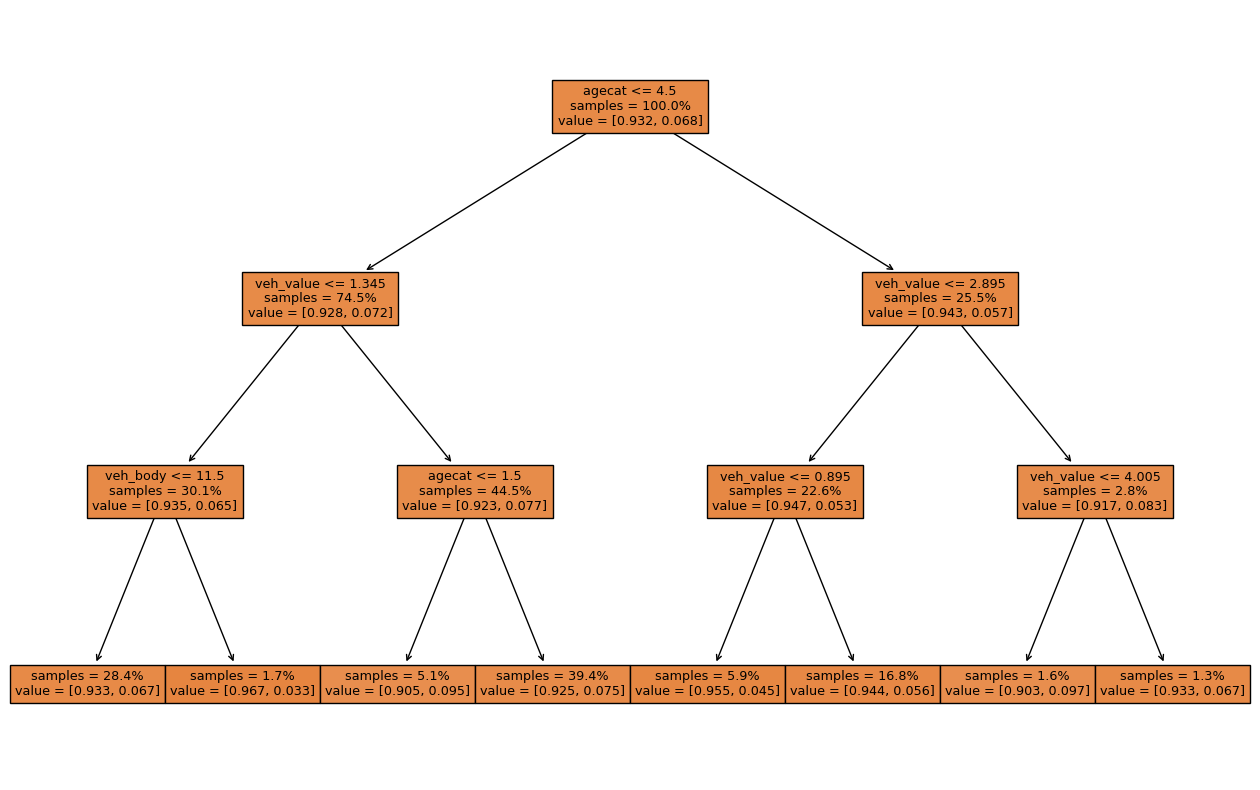

In [4]:
# Visualize and "read" tree
print("Fitted decision tree: if condition is 'yes', go to left!")
plt.figure(figsize=(16, 10))
_ = tree.plot_tree(
    model, feature_names=all_vars, proportion=True, filled=True, impurity=False
)

In [5]:
print("\nFirst observation (original and encoded)")
car[cat_vars].head(1)


First observation (original and encoded)


,gender,area,veh_body
0,F,C,HBACK


In [6]:
X[cat_vars].head(1)

,gender,area,veh_body
0,0.0,2.0,3.0


**Comments**

- The first observation belongs to a person in age category 2 and has a $10'600 hatchback: the first, second, and third question all send us to the left ("yes"). This gives us a claim probability of 6.7%.
- How was, e.g., the first question (`agecat <= 4.5`) chosen? The algorithm scans all covariates for all possible split positions and picks the one with best average loss improvement. In this case, splitting on covariate `agecat` at the value 4.5 reduced the average loss most.

**Properties of decision trees**

- **Outliers:** In contrast to linear models, outliers in covariates are not an issue because the algorithm only takes into account the sort order of the values. Similarly, taking logarithms in covariates has no effect. Both statements do not hold for the response variable.
- **Missing values:** Some implementations can deal with missing values in the input. Alternatively, missing values are often replaced by a typical value or a value smaller/larger than the smallest non-missing value (such as -1 for a positive variable).
- **Categorical covariates:** Unordered categorical covariates are tricky to split because with $\ell$ levels, theoretically, we end up with $2^\ell$ possible partitions. Try to lump small categories together or consider representing the levels by ordered categories (even if it does not make too much sense). One-hot-encoding is an option as well. Some algorithms offer ways to internally deal with unordered categoricals.
- **Greedy:** Partitions are made in a greedy way to optimize the objective in *one step*. Looking ahead more than one step would lead to better models but this is computationally too demanding in practice.
- **Interactions:** By their flexible structure, a decision tree can automatically capture interaction effects of any order (and other non-linear effects), at least if the data set is large and the tree is deep enough. This is a big advantage of tree-based methods compared to linear models where these elements have to carefully and manually be accounted for. In the next chapter, we will meet another model class with this advantage: neural nets.
- **Extrapolation:** By construction, a decision tree cannot extrapolate. So even a whopping 10 carat diamond cannot get a higher price prediction than the most expensive diamond in the training data.

These properties typically translate 1:1 to combinations of trees like random forests or boosted trees.

# Random Forests

## How they work

In 2001, Leo Breiman introduced a very powerful tree-based algorithm called *random forest*, see [2]. A random forest consists of many decision trees. To ensure that the trees differ, two sources or randomness are injected:

1. Each tree is calculated on a bootstrap sample of the data, i.e., on $n$ observations selected with replacement from the original $n$ rows. This technique is called "bagging", from "**b**ootstrap **agg**regat**ing**". 
2. Each split scans only a random selection "mtry" of the $m$ covariates to find the best split, usually about $\sqrt{m}$ or $m/3$. "mtry" is the main tuning parameter of a random forest.

Predictions are found by pooling the predictions of all trees, e.g., by averaging or majority voting.

**Comments about random forests**

- **Number of trees:** Usually, 100-1000 trees are being grown. The more, the better. More trees also mean longer training time and larger models.
- **Diversification:** Single trees in a random forest are usually very deep. They overfit on the training data. It is the diversity across trees that produces a good and stable model, just with a well-diversified stock portfolio. 
- **Never trust performance on the training set for random forests.**
- **OOB validation**: In each tree, about 1/3 of all observations are not in the bootstrap sample just by chance. Put differently: each observation is used in about 2/3 of all trees. If its prediction is calculated from the other 1/3 of the trees, we get an "out-of-sample" prediction, also called "out-of-bag" (OOB) prediction. If rows are independent, model performance derived from these OOB predictions is usually good enough to be used for model validation. Do not use OOB results when rows are dependent such as for grouped samples.
- **Parameter tuning:** Random forests offer many tuning parameters. Since the results typically do not depend too much on their choice, untuned random forests are often great benchmark models.

## Example: random forest

Let us now fit a random forest for diamond prices with typical parameters and 500 trees. 80% of the data is used for training, the other 20% we use for evaluating the performance. (Throughout the rest of the lecture, we will ignore the problematic aspect of having repeated rows for some diamonds.)

In [7]:
diamonds = pd.read_parquet("diamonds.parquet")  # Or sns.load_dataset("diamonds")

# Train/test split
df_train, df_test, y_train, y_test = train_test_split(
    diamonds, diamonds["price"], test_size=0.2, random_state=49
)

# Preprocessing
ord_vars = ["color", "cut", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in ord_vars]

tree_encoder = ColumnTransformer(
    [
        ("num", "passthrough", ["carat"]),
        ("ord", OrdinalEncoder(categories=ord_levels), ord_vars),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Combine with random forest into clean pipeline
model = make_pipeline(
    tree_encoder,
    RandomForestRegressor(
        n_estimators=500,
        max_features="sqrt",
        min_samples_leaf=5,
        oob_score=True,
        random_state=17,
        n_jobs=4,
    ),
)

In [8]:
model.fit(df_train, y_train)

# OOB performance
print(f"OOB R-squared: {model[-1].oob_score_:.2%}")

OOB R-squared: 98.06%


In [9]:
# Test performance
dummy = DummyRegressor().fit(df_train, y_train)

mse_0, mse = (
    mean_squared_error(y_test, mod.predict(df_test)) for mod in (dummy, model)
)

print(f"Test RMSE: {np.sqrt(mse):.3f}")
print(f"Test R-squared: {(mse_0 - mse) / mse_0:.2%}")

Test RMSE: 557.518
Test R-squared: 98.06%


**Comments**

- Performance is excellent.
- The OOB estimate of performance is extremely close to the test set performance.
- Interpretation?

## Interpreting a "black box"

In contrast to a single decision tree or a linear model, a combination of many trees is not easy to interpret. It is good practice for any ML model to study at least *variable importance* and the strongest *effects*, not just its performance. A pure prediction machine is hardly of any interest and might even contain mistakes like using covariates derived from the response. Model interpretation helps to fight such problems and thus also to increase trust in a model.

### Variable importance

There are different approaches to measure the importance of a covariate. Since there is no general mathematical definition of "importance", the results of different approaches might be inconsistent across each other. For tree-based methods, a usual approach is to measure how many times a covariate $X$ was used in a split or how much total loss improvement came from splitting on $X$.

Approaches that work for *any* supervised model (including neural nets) include **permutation importance** and **SHAP importance**.

### Effects

One of the main reasons for the success of modern methods like random forests is the fact that they automatically learn interactions between two or more covariates. Thus, the effect of a covariate $X$ typically depends on the values of other covariates. In the extreme case, the effect of $X$ is different for each observation. The best what we can do is to study the *average effect* of $X$ over many observations, i.e., averaging the effects over interactions. This leads us to **partial dependence plots**: They work for any supervised ML model and are constructed as follows: A couple of observations are selected. Then, their average prediction is visualized against $X$ when sliding their value of $X$ over a reasonable grid of values, *keeping all other variables fixed*. The more natural the Ceteris Paribus clause, the more reliable the partial dependence plots.

Remark: A partial dependence plot of a covariate in a linear regression is simply a visualization of its coefficient.

Alternatives to partial dependence plots include **accumulated local effect plots** and **SHAP dependence plots**. Both relax the Ceteris Paribus clause.

## Example: random forest (continued)

For our last example, we will now look at variable importance and partial dependence plots.

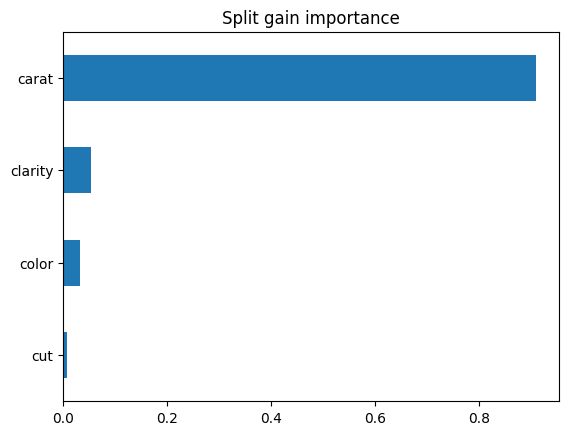

In [10]:
# Variable importance
feature_names = model[0].get_feature_names_out()
imps = pd.Series(model[-1].feature_importances_, index=feature_names)
_ = imps.sort_values().plot(kind="barh", title="Split gain importance")

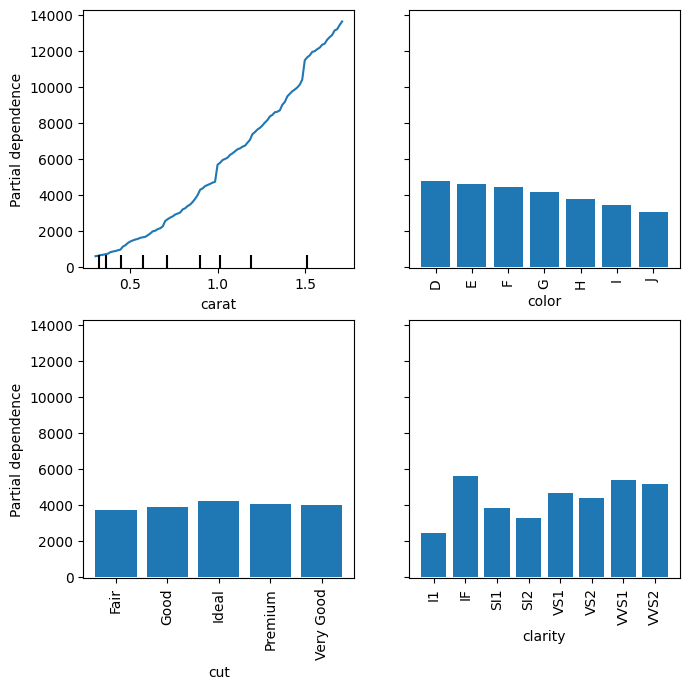

In [11]:
fig, axes = plt.subplots(figsize=(7, 7))

# Note that the categorical levels are in alphabetic order, not in the correct one
PartialDependenceDisplay.from_estimator(
    model,
    features=feature_names,
    categorical_features=ord_vars,
    X=df_train.sample(n=1000, random_state=1),
    n_cols=2,
    ax=axes,
)
fig.tight_layout()

**Comments**

- As expected, `carat` is the most important predictor.
- All effects as assessed by partial dependence make sense.

## Exercises

1. In above example, replace carat by its logarithm. Do the results change compared to the example without logs?
2. Fit a random forest on the claims data for the binary variable `clm` using covariates `veh_value`, `veh_body`, `veh_age`, `gender`, `area`, and `agecat`. Choose a suitable tree depth either by cross-validation or by minimizing OOB error on the training data. Make sure to fit a *probability random forest*, i.e., predicting probabilities, not classes. Additionally, make sure to work with a relevant loss function (information/cross-entropy or Gini gain). Evaluate the final model on an independent test dataset. Interpret the results by split gain importance and partial dependence plots.

# Gradient Boosted Trees

The idea of *boosting* was introduced by Schapire in 1990 [3] and roughly works as follows: A simple model is fit to the data. Then, another simple model is added, trying to correct the errors from the first model. This process is repeated until some stopping criterion triggers. As simple models or *base learners*, usually **small decision trees** are used, an idea pushed by Jerome Friedman in his famous 2001 article on the very general framework of gradient boosting machines [4]. 

Modern variants of such *gradient boosted trees* are [XGBoost](https://xgboost.readthedocs.io/en/latest/), [LightGBM](https://lightgbm.readthedocs.io/en/latest/) and [CatBoost](https://catboost.ai/). These are the predominant algorithms in ML competitions on tabular data, check [this comparison](https://github.com/mayer79/gradient_boosting_comparison) for differences with a screenshot as per Oct. 20, 2022:

<img src="../figs/comparison_boosting.PNG" width="40%">

Predictions are calculated similar to random forests, i.e., by combining predictions of all trees. As loss/objective function, one can choose among many possibilities. Often, using the same loss function as a corresponding GLM is a good choice.

## Example: XGBoost

As an initial example on gradient boosting and XGBoost, we fit a model for diamond prices with squared error as loss function. The number of rounds/trees is initially chosen by cross-validation and early stopping, i.e., until CV validation (R)MSE stops improving for a couple or rounds. The learning rate (weight of each tree) is chosen by trial and error in order to end up with a reasonably small/large number of trees, see the next section for more details.

In [12]:
#  We can reuse the tree_encoder of the random forest
dtrain = xgb.DMatrix(tree_encoder.transform(df_train), label=y_train)
dtest = xgb.DMatrix(tree_encoder.transform(df_test))

# Compact set of parameters
params = {"objective": "reg:squarederror", "learning_rate": 0.02}

In [13]:
# Add trees until CV validation MSE stops improving over the last 20 rounds
fit_cv = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,  # a large value
    early_stopping_rounds=20,
    callbacks=[xgb.callback.EvaluationMonitor(period=50)],
)

# Best boosting round
fit_cv.tail(1)

[0]	train-rmse:3910.87196	test-rmse:3911.11969


[50]	train-rmse:1584.25050	test-rmse:1590.82075
[100]	train-rmse:811.28697	test-rmse:827.92826
[150]	train-rmse:592.21045	test-rmse:619.36242
[200]	train-rmse:536.51516	test-rmse:570.19446
[250]	train-rmse:519.59778	test-rmse:558.05271
[300]	train-rmse:512.56702	test-rmse:554.44458
[350]	train-rmse:507.52082	test-rmse:553.43900
[386]	train-rmse:504.73876	test-rmse:553.48197


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
366,506.253669,4.902599,553.362017,10.183052


In [14]:
# Fit model on full training data using optimal number of boosting round
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=len(fit_cv))

rmse = root_mean_squared_error(y_test, model.predict(dtest))
print(f"Test RMSE: {rmse:.3f}")

Test RMSE: 550.390


**Comments:** 

- More trees would mean better training performance, but worse CV performance.
- Test performance is slightly better than the random forest. Can we do even better?
- In the next example, we will also interpret such a model.

## Parameters of gradient boosted trees

Gradient boosted trees offer a quite a lot of parameters. Unlike with random forests, they need to be tuned to achieve good results. It would be naive to use an algorithm like XGBoost without parameter tuning. Here is a selection:

- **Number of boosting rounds:** In contrast to random forests, more trees/rounds is not always beneficial because the model begins to overfit after some time. The optimal number of rounds is usually found by early stopping, i.e., one lets the algorithm stop as soon as the (cross-)validation performance stops improving, see the example above.

- **Learning rate:** The learning rate determines training speed and the impact of each tree to the final model. Typical values are between 0.01 and 0.5. In practical applications, it is set to a value that leads to a reasonable amount of trees (100-1000). Usually, halving the learning rate means twice as much boosting rounds for comparable performance.

- **Regularization parameters:** Depending on the implementation, additional parameters are
    - the tree depth (often 3-7) or the number of leaves (often 7-63), 
    - the strength of the L1 and/or L2 penalties added to the objective function (often between 0 and 5), 
    - the row subsampling rate (often between 0.8 and 1), 
    - the column subsampling rate (often between 0.6 and 1), 
    - ...
  
  Reasonable regularization parameters are chosen by trial and error or systematically by randomized or grid search CV. Usually, it takes a couple of iterations until the range of the parameter values have been set appropriately.

Overall, the modelling strategy is as follows:

1. Using default regularization parameters, set the learning rate to get reasonable number of trees with CV-based early stopping.
2. Use randomized search CV with early stopping to tune regularization parameters such as tree depth. Iterate if needed.
3. Use the best parameter combination (incl. number of trees) to fit the model on the training data. "Best" typically means in terms of CV performance. As mentioned in the last chapter and depending on the situation, it can also mean "good CV performance and not too heavy overfit compared to insample performance" or some other reasonable criterion.

Note: Since learning rate, number of boosting rounds and regularization parameters are heavily interdependent, a "big" randomized grid search CV to choose learning rate, boosting rounds and regularization is often not ideal. Above suggestion (fix learning rate, select number of rounds by early stopping and do grid search only on regularization parameters) is more focussed, see also the example below.

## Example: XGBoost (fully tuned)

We will use XGBoost to fit diamond prices using the squared error as loss function and RMSE as evaluation metric, now using the tuning strategy outlined above.

In [15]:
grid_file = Path("gridsearch") / "diamonds_xgb.txt"

# Step 1: See last example. A learning rate of 0.02 seems to be appropriate
# Step 2: Iterate randomized SearchCV for regularization parameters
if False:
    # Use ParameterGrid(...) if grid is small enough to check all combinations
    # Final grid search after some iterations
    grid = ParameterSampler(
        {
            "objective": ["reg:squarederror"],
            "learning_rate": [0.02],
            "max_depth": [4, 5, 6],
            "colsample_bynode": [0.8, 1],
            "subsample": [0.8, 1],
            "reg_lambda": [0, 1, 2],
            "reg_alpha": [0, 1, 2],
            "min_split_loss": [0, 0.0001],
            "min_child_weight": [1, 10],
        },
        n_iter=32,
        random_state=4,
    )

    # Iterate over grid and save relevant information on disk
    search = []
    for g in tqdm(grid):
        cvm = xgb.cv(
            params=g,
            dtrain=dtrain,
            num_boost_round=5000,
            nfold=5,
            seed=60,
            early_stopping_rounds=20,
        )
        # Keep number of rounds, cv score, train score, and parameters
        search.append((len(cvm), *cvm.iloc[-1, [2, 0]], g))

        with open(grid_file, "w") as f:
            json.dump(search, f)

# Load grid and check (A) sort order and (B) if grid ranges were set reasonable
with open(grid_file) as f:
    search = json.load(f)

search_df = pd.DataFrame.from_records(
    search, columns=["num_boost_round", "cv_score", "train_score", "params"]
).sort_values("cv_score")

with pd.option_context("display.max_colwidth", None):
    display(search_df.head())

,num_boost_round,cv_score,train_score,params
23,355,543.474377,509.026808,"{'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0, 'objective': 'reg:squarederror', 'min_split_loss': 0.0001, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.02, 'colsample_bynode': 0.8}"
13,434,543.498781,513.506725,"{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'objective': 'reg:squarederror', 'min_split_loss': 0, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.02, 'colsample_bynode': 0.8}"
2,413,543.682467,511.658574,"{'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 1, 'objective': 'reg:squarederror', 'min_split_loss': 0.0001, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.02, 'colsample_bynode': 1}"
25,434,543.686083,512.054070,"{'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 1, 'objective': 'reg:squarederror', 'min_split_loss': 0, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.02, 'colsample_bynode': 0.8}"
27,430,543.886060,512.533011,"{'subsample': 1, 'reg_lambda': 2, 'reg_alpha': 0, 'objective': 'reg:squarederror', 'min_split_loss': 0.0001, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.02, 'colsample_bynode': 0.8}"


In [16]:
# Step 3: Fit on best params. Note that we now switch to the Scikit-Learn API,
# e.g., in order to simplify model interpretation (scoring, partial dependence)
best = search_df.iloc[0]
best.num_boost_round, best.params

(355,
 {'subsample': 0.8,
  'reg_lambda': 0,
  'reg_alpha': 0,
  'objective': 'reg:squarederror',
  'min_split_loss': 0.0001,
  'min_child_weight': 1,
  'max_depth': 6,
  'learning_rate': 0.02,
  'colsample_bynode': 0.8})

In [17]:
xgbmodel = XGBRegressor(
    **best.params,
    n_estimators=best.num_boost_round,
    random_state=5,
    importance_type="gain",
)
_ = model = make_pipeline(tree_encoder, xgbmodel).fit(X=df_train, y=y_train)

Now, the model is ready to be inspected by evaluating 

- test performance, 
- split gain importance and 
- partial dependence plots.

In [18]:
# Test performance
dummy = DummyRegressor().fit(df_train, y_train)

mse_0, mse = (
    mean_squared_error(y_test, mod.predict(df_test)) for mod in (dummy, model)
)

print(f"Test RMSE: {np.sqrt(mse):.3f}")
print(f"Test R-squared: {(mse_0 - mse) / mse_0:.2%}")

Test RMSE: 549.506
Test R-squared: 98.11%


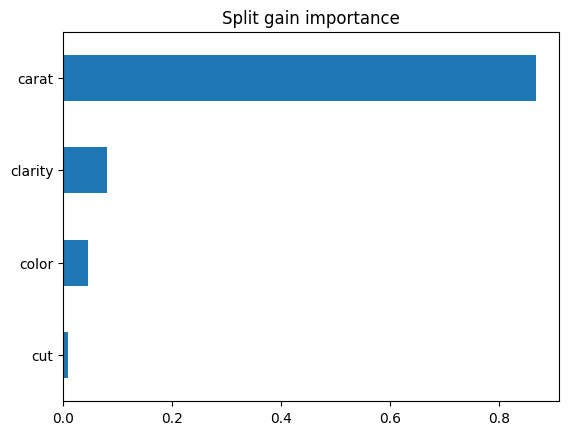

In [19]:
# Split gain importance
feature_names = model[:-1].get_feature_names_out()
imps = pd.Series(model[-1].feature_importances_, index=feature_names)
_ = imps.sort_values().plot.barh(title="Split gain importance")

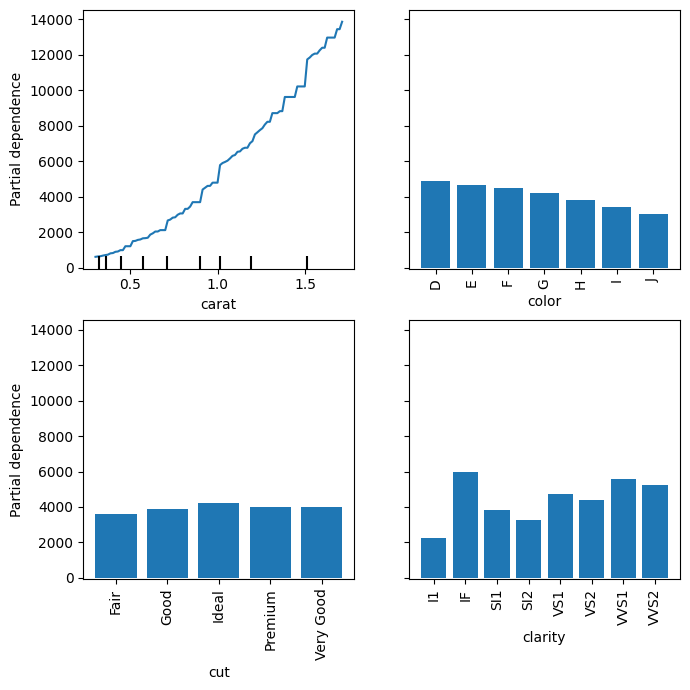

In [20]:
# Partial dependence plots on training data
fig, axes = plt.subplots(figsize=(7, 7))

PartialDependenceDisplay.from_estimator(
    model,
    features=feature_names,
    categorical_features=ord_vars,
    X=df_train.sample(n=1000, random_state=1),
    n_cols=2,
    ax=axes,
)
fig.tight_layout()

**Comment**: The resulting model seems comparable to the random forest with slightly better performance. The grid search did not significantly improve the results in this case.

## Exercises

1. Study the online documentation of XGBoost to figure out how to force the model to be monotonically increasing in carat. Test your insights without rerunning the grid search in our last example, i.e., just by refitting the final model. How does the partial dependence plot for `carat` look now?
2. Develop a strong XGBoost model for the claims data set with binary response `clm` and covariates `veh_value`, `veh_body`, `veh_age`, `gender`, `area`, and `agecat`. Use a clean cross-validation/test approach. Use log loss as loss function and evaluation metric. Interpret its results.
3. Optional. Study the documentation of [LightGBM](https://lightgbm.readthedocs.io/en/latest/). Use LightGBM to develop a competitor to the XGBoost claims model from Exercise 2. The XGBoost code needs to be slightly adapted. Compare grid search time.

# Chapter Summary

In this chapter, we have met decision trees, random forests and tree boosting. Single decision trees are very easy to interpret but do not perform too well. On the other hand, tree ensembles like the random forest or gradient boosted trees usually perform very well but are tricky to interpret. We have introduced interpretation tools to look into such "black boxes". The main reason why random forests and boosted trees often provide more accurate models than a linear model lies in their ability to automatically learn interactions and other non-linear effects.

# Chapter References

[1] L. Breiman, J. Friedman, R. Olshen, and C. Stone, "Classification and Regression Trees", Wadsworth, Belmont, CA, 1984.

[2] L. Breiman, "Random forests". In: Machine Learning, 2001, 45(1).

[3] R. Schapire, "The strength of weak learnability", Machine Learning, Vol 5, Nr. 2, 1990.

[4] J. Friedman, "Greedy Function Approximation: A Gradient Boosting Machine", 2001.